## Load dependencies

In [5]:
import os

import torch 
import torch.nn as nn
from torch.optim import SGD, Adam, RMSprop
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, Subset

from PIL import Image, ImageOps
import matplotlib.pyplot as plt

from unet.Unet import *

#### Update-1: To increase train time
   - Store low resolution(decent) images locally and then load to data loader
   - Increase batch size - will increase gpu utilisation, will increase performance. Don't have it too high. Can lead to overfitting
   
   - Apply some augmentation so that increasing batch size won't quickly leadly to overfitting.
    

In [6]:
# %%time
# input_dir = ['data/imgs', 'data/masks']
# output_dir = ['data_resized/imgs','data_resized/masks']

# size = (576, 576)
# for i in range(2):
#     for filename in os.listdir(input_dir[i]):
#         img = Image.open(os.path.join(input_dir[i], filename))

#         img_resized = img.resize(size)

#         output_path = os.path.join(output_dir[i], filename)
#         img_resized.save(output_path)

In [7]:
device = 'cuda' ## 'mps' in apple silicon

In [8]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    #  576 choosen because, height and width would be even after 4 maxpooling
#     transforms.Resize([576, 576]),
])

## Dataset preparation

In [9]:
class SegmentationDataset(Dataset):
    
    def __init__(self, imagePaths, maskPaths, transforms):

        self.imagefiles = os.listdir(imagePaths)
        self.maskfiles = os.listdir(maskPaths)
        
        if  '.DS_Store' in self.imagefiles:
            self.imagefiles.remove( '.DS_Store')
        if  '.DS_Store' in self.maskfiles:
            self.maskfiles.remove( '.DS_Store')
            
        self.imagefiles.sort()
        self.maskfiles.sort()
    
        for i in range(len(self.imagefiles)):
            self.imagefiles[i] = os.path.join(imagePaths,self.imagefiles[i])
            self.maskfiles[i] = os.path.join(maskPaths, self.maskfiles[i])
        
        self.transforms = transforms
        
    def __len__(self):
        return len(self.imagefiles)
    
    def __getitem__(self, idx):
        imagePath = self.imagefiles[idx]
        maskPath = self.maskfiles[idx]
        
        image =Image.open(imagePath)
        #m = Image.open(maskPath).convert('A')
        mask =Image.open(maskPath)
        mask = ImageOps.grayscale(mask)
        
        image = self.transforms(image)
        mask = self.transforms(mask)
        
        return (image, mask)

In [10]:
#dataset = SegmentationDataset('/kaggle/input/data-resized/data_resized/imgs', '/kaggle/input/data-resized/data_resized/masks', train_transform)
dataset = SegmentationDataset('/data_resized/imgs', 'data_resized/masks', train_transform)

## Prepare Dataloader

In [11]:
torch.manual_seed(1)

total = len(dataset)
train_size = 0.75

train_total = int(train_size * total)
test_total = int((1-train_size )* total)

valid_total =  int((1-train_size) * train_total)
actual_train_total = int(train_size * train_total)


print(f'Train size: {actual_train_total} \nValidation Size: {valid_total} \nTest Size: {test_total}') 

Train size: 2862 
Validation Size: 954 
Test Size: 1272


In [12]:
randomised_idx = torch.randperm(total)

data_train = Subset(dataset, randomised_idx[:train_total])
data_test = Subset(dataset, randomised_idx[train_total: ])

data_train = Subset(dataset,randomised_idx[:actual_train_total])
data_valid = Subset(dataset, randomised_idx[actual_train_total: actual_train_total + valid_total])

In [13]:
len(data_train), len(data_valid), len(data_test)

(2862, 954, 1272)

In [14]:
data = DataLoader(data_train, batch_size=5, shuffle=True)
data_vl = DataLoader(data_valid, batch_size=5, shuffle=True)

In [15]:
next(iter(data))[0].shape

torch.Size([5, 3, 576, 576])

## Visualise data

In [16]:
import numpy as np

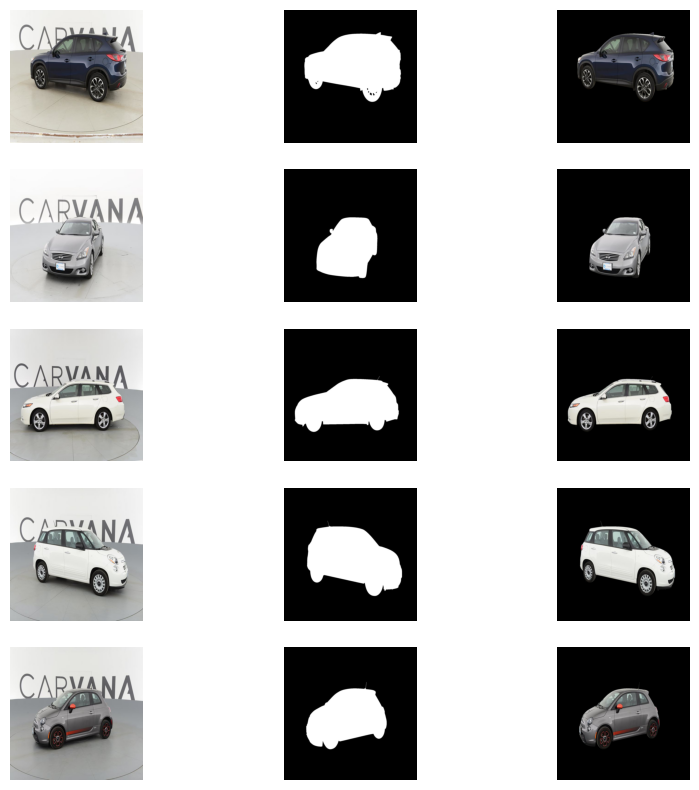

In [17]:
viz_data = DataLoader(data_train, 5, shuffle=False)

image_batch, mask_batch = next(iter(viz_data))
plt.figure(figsize=(10,10))

for i in range(1,16, 3):
    image_proper = (image_batch[i//3].permute(1,2,0))
    mask_proper = (mask_batch[i//3].permute(1,2,0))
    
    plt.subplot(5,3,i)
    plt.axis('off')
    plt.imshow(image_proper)
    
    plt.subplot(5,3,i+1)
    plt.axis('off')

    plt.imshow(mask_proper.squeeze(2), cmap='gray')
    
    plt.subplot(5,3,i+2)
    mask = mask_proper.permute(2,0,1)
    mask = transforms.ToPILImage()(mask)
    mask = transforms.Grayscale(num_output_channels=3)(mask)
    image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

    image_masked = image_masked.numpy().transpose(1, 2, 0)
    plt.axis('off')
    plt.imshow(np.uint8(image_masked))
    

plt.show()

## Training step

In [18]:
model = UNet(3, 1)
model

UNet(
  (initial): InsideBlockConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): ContractionBlock(
    (contraction): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): InsideBlockConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm

In [19]:
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.99)
loss_fn = nn.CrossEntropyLoss() if model.n_classes > 1 else nn.BCEWithLogitsLoss()


In [20]:
from torchmetrics import JaccardIndex # i.e IoU

In [21]:
def train(model, epoch, data, data_vl):
    train_loss = [0] * epoch
    train_jaccard = [0] * epoch
    validation_loss = [0] * epoch
    validation_jaccard = [0] * epoch
    for i in range(epoch):
        for x_batch, y_batch in data:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss[i] += (loss.item() * x_batch.size(0))
            
            y_batch = y_batch.to(torch.int)
            pred = torch.sigmoid(pred) ## Must needed
            pred = torch.round(pred).to(torch.int)
            jaccard = JaccardIndex(task="binary")
            #print(jaccard(pred.cpu(), y_batch.cpu()))
            train_jaccard[i] += jaccard(pred.cpu(), y_batch.cpu()) ## Find out how it is calculated with batch size
            
        div = len(data.dataset)//data.batch_size
        
        train_loss[i] /= len(data.dataset)
        train_jaccard[i] /= div
        print('Train over, validation begins...')
        with torch.no_grad():
            for x_batch, y_batch in data_vl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                validation_loss[i] += (loss.item() * x_batch.size(0))
                
                y_batch = y_batch.to(torch.int) 
                pred = torch.sigmoid(pred)
                pred = torch.round(pred).to(torch.int)

                jaccard = JaccardIndex(task="binary")
                validation_jaccard[i] += jaccard(pred.cpu(), y_batch.cpu())
                
            div = len(data_vl.dataset)//data_vl.batch_size
            validation_loss[i] /= len(data_vl.dataset)
            validation_jaccard[i] /= div
        print(f'Epoch {i+1} \nloss: {train_loss[i]:.4f} val_loss:{validation_loss[i]:.4f}\njaccard: {train_jaccard[i]:.4f} val_jaccard:{validation_jaccard[i]:.4f}')
        print()
    return train_loss, train_jaccard, validation_loss, validation_jaccard

In [22]:
data_sub_train = Subset(data_train, np.arange(10))
datasub = DataLoader(data_sub_train, batch_size=5, shuffle=True)

In [23]:
%%time
### When train batch size=1 and validation batch=1,  resized image loaded by dataloader
  
model = model.to(device)
epoch = 4
train_loss, train_iou, validation_loss, validation_iou = train(model, epoch, data, data_vl)

Train over, validation begins...
Epoch 1 
loss: 0.0712 val_loss:0.0264
jaccard: 0.8664 val_jaccard:0.9378

Train over, validation begins...
Epoch 2 
loss: 0.0252 val_loss:0.0186
jaccard: 0.9327 val_jaccard:0.9466

Train over, validation begins...
Epoch 3 
loss: 0.0167 val_loss:0.0156
jaccard: 0.9444 val_jaccard:0.9527

Train over, validation begins...
Epoch 4 
loss: 0.0143 val_loss:0.0129
jaccard: 0.9479 val_jaccard:0.9509

CPU times: user 47min 5s, sys: 7.68 s, total: 47min 13s
Wall time: 48min 24s


#### Note, when batch size was 1, it took 1 hr 20 minutes for training. But with batch size 5, training time is reduced as expected.

In [19]:
ls

LICENSE             Segmentation.ipynb  download.sh*        unet/

README.md           data/               images/


In [24]:
len(data_test)

1272

In [28]:
image , mask = data_test[120][0], data_test[120][1]

image = image.unsqueeze(0)
image = image.to(device)

pred = model(image).squeeze(0).cpu().detach()
image = image.squeeze(0).cpu()
pred = torch.sigmoid(pred)
print(pred)
pred = torch.round(pred) ## Must needed for proper segmented display
print(pred)

tensor([[[5.0930e-04, 1.8256e-04, 1.2782e-04,  ..., 3.1483e-04,
          5.1244e-04, 8.6232e-04],
         [1.6046e-04, 2.6217e-05, 1.5652e-05,  ..., 6.2866e-05,
          1.6623e-04, 5.8669e-04],
         [1.0576e-04, 1.4413e-05, 1.0481e-05,  ..., 5.1925e-05,
          1.3759e-04, 5.3849e-04],
         ...,
         [5.8531e-04, 2.4458e-04, 2.0078e-04,  ..., 3.4466e-05,
          1.0169e-04, 4.6938e-04],
         [7.8750e-04, 3.2730e-04, 2.5215e-04,  ..., 4.2846e-05,
          1.2753e-04, 5.3743e-04],
         [1.1688e-03, 9.1989e-04, 7.2846e-04,  ..., 2.0820e-04,
          4.3502e-04, 8.1201e-04]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


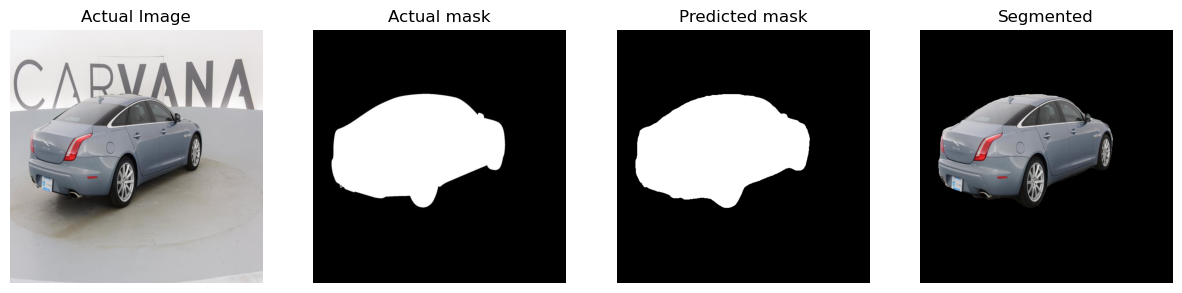

In [29]:
image_proper = (image.permute(1,2,0))
mask_proper = (mask.permute(1,2,0))
predicted_mask_proper = (pred.permute(1,2,0))

plt.figure(figsize=(15,35))
plt.tight_layout()
plt.subplot(5,4,i)
plt.title('Actual Image')
plt.axis('off')
plt.imshow(image_proper)

plt.subplot(5,4,i+1)
plt.title('Actual mask')
plt.axis('off')
plt.imshow(mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+2)
plt.title('Predicted mask')
plt.axis('off')
plt.imshow(predicted_mask_proper.squeeze(2), cmap='gray')

plt.subplot(5,4,i+3)
plt.title('Segmented')
mask = predicted_mask_proper.permute(2,0,1)
mask = transforms.ToPILImage()(mask)
mask = transforms.Grayscale(num_output_channels=3)(mask)
image_masked = transforms.functional.pil_to_tensor(mask) * image_proper.permute(2,0,1)

image_masked = image_masked.numpy().transpose(1, 2, 0)
plt.axis('off')
plt.imshow(np.uint8(image_masked))

#### Remarks
- Pretty good mask is predicted.

**End Note**
- Trained with Kaggle GPU. 30 hours per week of GPU usage is an amazing free plan. I encourage everyone to use Kaggle GPU for training heavy models.